### **1. Import the Required Libraries**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### **2. Load the Image Training and Validation Datasets**

#### **i. Get the Image Dataset Paths**

In [3]:
train_dataset_path = '/kaggle/input/pothole-data/My_Dataset/train/'
validation_dataset_path = '/kaggle/input/pothole-data/My_Dataset/test/'

#### **ii. Load Image Datasets and Apply Augmentations**

Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [4]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

Loading the training dataset and applying augmentations on it.

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 5075 images belonging to 2 classes.


Loading the validation dataset.

In [6]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 1021 images belonging to 2 classes.


#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Plain
1 : Pothole


### **3. Plotting Sample Training Images**

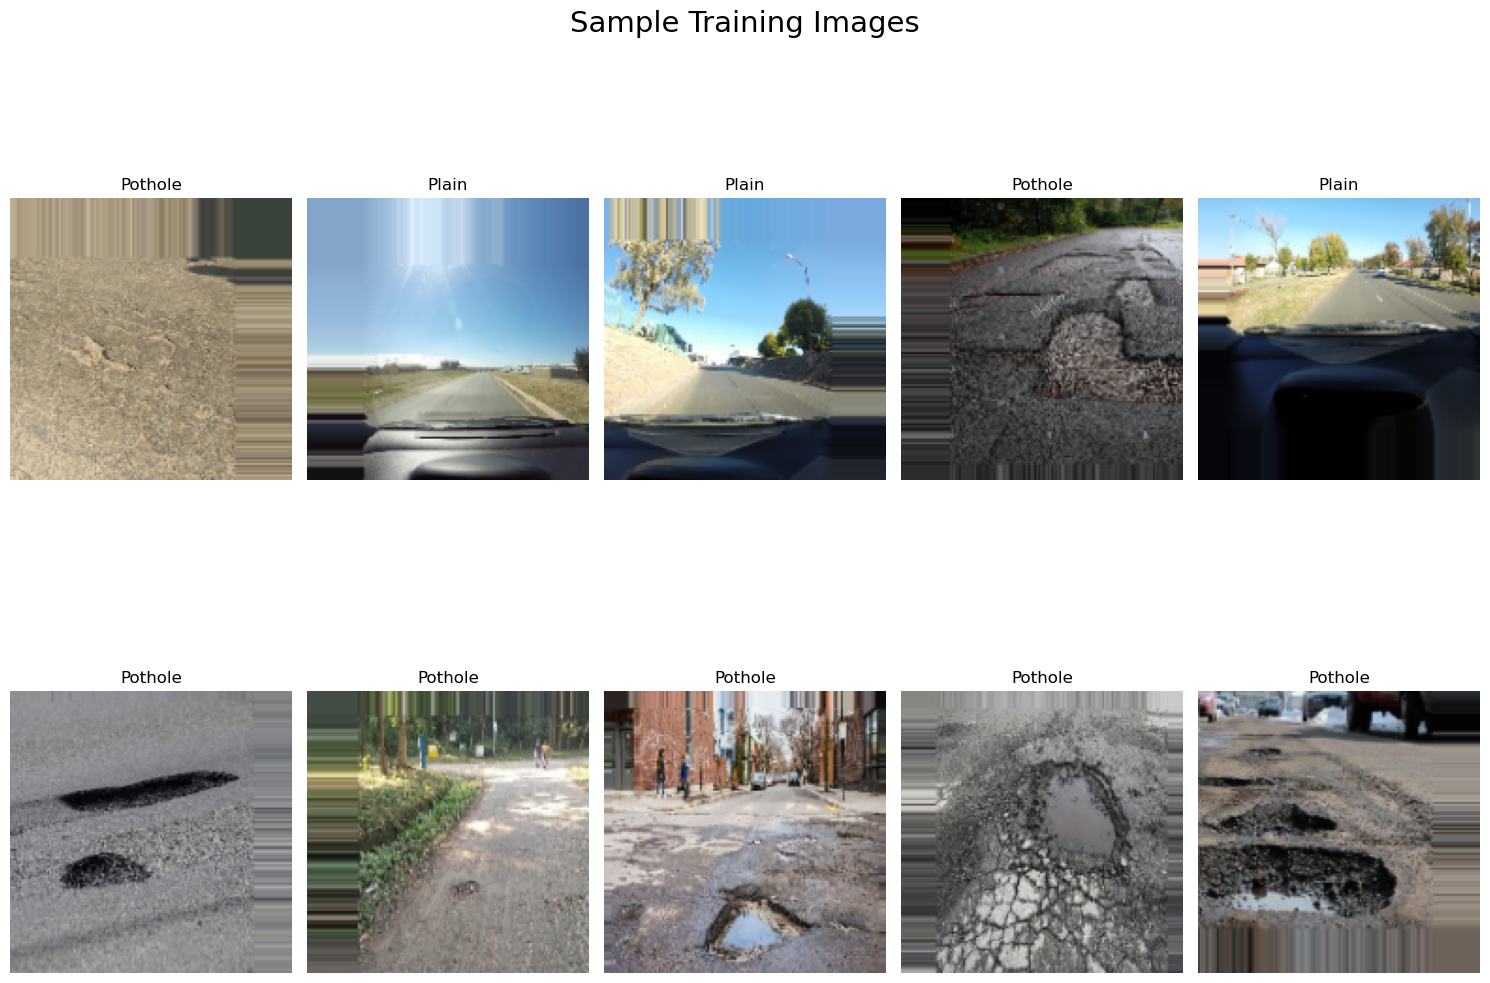

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

### **4. Training a CNN Model**

Since the training dataset is ready let's create a simple CNN Model to train on the image datasets

#### **i. Create a CNN Model**

In [9]:
def create_model():
    model = Sequential([
        Conv2D(filters=256, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(units=2, activation='sigmoid')
    ])

    return model

In [10]:
cnn_model = create_model()

In [11]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 256)     19456     
                                                                 
 activation (Activation)     (None, 146, 146, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 256)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       819328    
                                                                 
 activation_1 (Activation)   (None, 69, 69, 128)       0

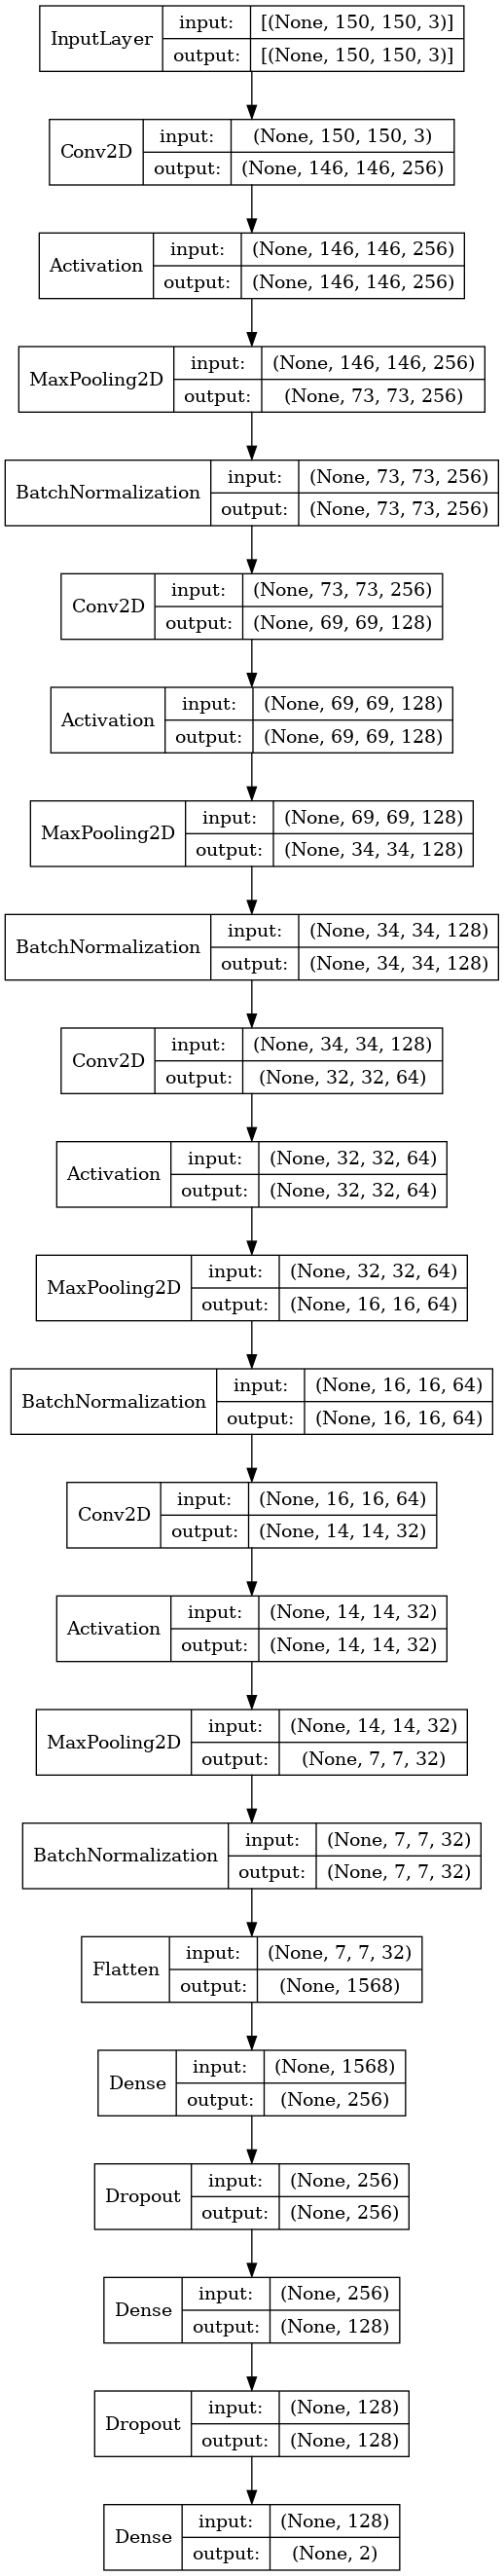

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(cnn_model, expand_nested=True, show_shapes=True, show_layer_names=False)

#### **ii. Defining Callbacks**

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [13]:
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

#### **iii. Defining the Optimizer**

In [14]:
optimizer = Adam(learning_rate=0.00001)

#### **iv. Compile the Model**

In [15]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

#### **v. Training the Model**

In [16]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2)

Epoch 1/50
159/159 - 125s - loss: 0.7177 - accuracy: 0.7316 - val_loss: 1.2255 - val_accuracy: 0.5015 - 125s/epoch - 787ms/step
Epoch 2/50
159/159 - 62s - loss: 0.3085 - accuracy: 0.8843 - val_loss: 1.9242 - val_accuracy: 0.5015 - 62s/epoch - 389ms/step
Epoch 3/50
159/159 - 63s - loss: 0.1963 - accuracy: 0.9300 - val_loss: 1.3847 - val_accuracy: 0.5230 - 63s/epoch - 396ms/step
Epoch 4/50
159/159 - 63s - loss: 0.1479 - accuracy: 0.9529 - val_loss: 0.7678 - val_accuracy: 0.7551 - 63s/epoch - 397ms/step
Epoch 5/50
159/159 - 63s - loss: 0.1153 - accuracy: 0.9643 - val_loss: 0.6518 - val_accuracy: 0.7973 - 63s/epoch - 397ms/step
Epoch 6/50
159/159 - 62s - loss: 0.1120 - accuracy: 0.9689 - val_loss: 0.7370 - val_accuracy: 0.8051 - 62s/epoch - 392ms/step
Epoch 7/50
159/159 - 64s - loss: 0.1019 - accuracy: 0.9734 - val_loss: 0.6564 - val_accuracy: 0.8247 - 64s/epoch - 403ms/step
Epoch 8/50
159/159 - 63s - loss: 0.0864 - accuracy: 0.9764 - val_loss: 0.6694 - val_accuracy: 0.8335 - 63s/epoch - 3

### **5. Plotting the Model Metrics**

#### **i. Plotting training and validation accuracy, loss and learning rate**

In [17]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']


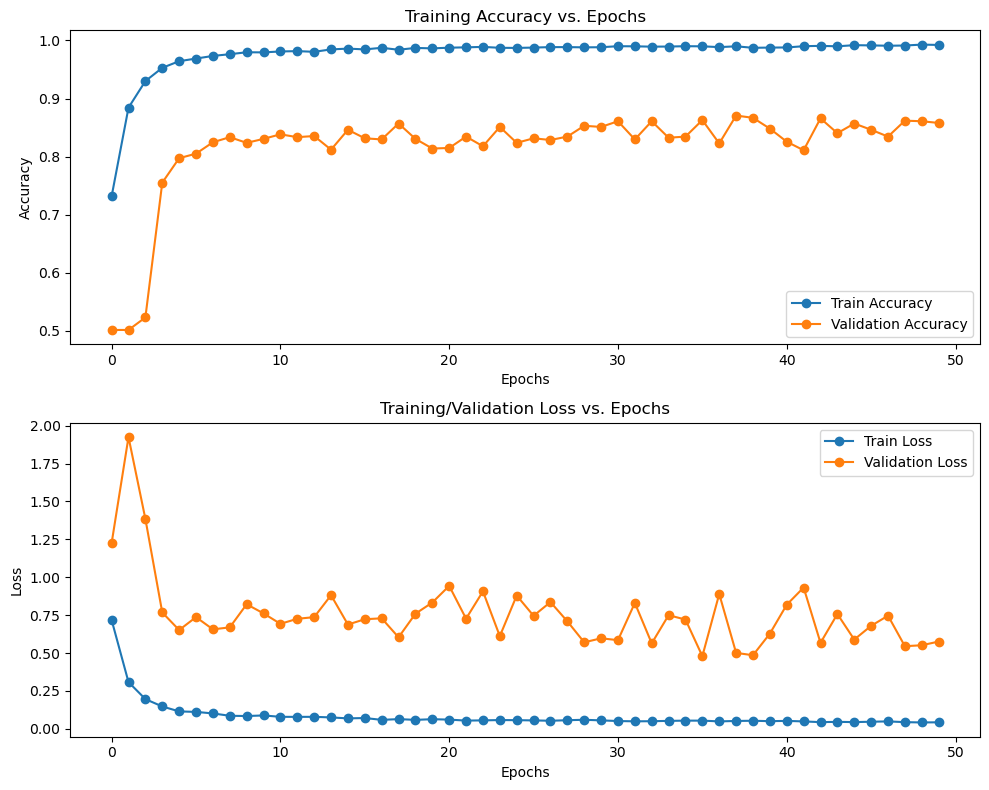

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')


plt.tight_layout()
plt.show()

### **6. Testing the Model on Test Set**

Testing the model on the validation dataset because a seperate dataset for testing is not available.

In [19]:
test_dataset = '/kaggle/input/pothole-data/My_Dataset/test/'

In [20]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 1021 images belonging to 2 classes.


### **7. Model Prediction on the Test Dataset**

In [21]:
predictions = cnn_model.predict(test_generator)

32/32 [==============================] - 4s 111ms/step


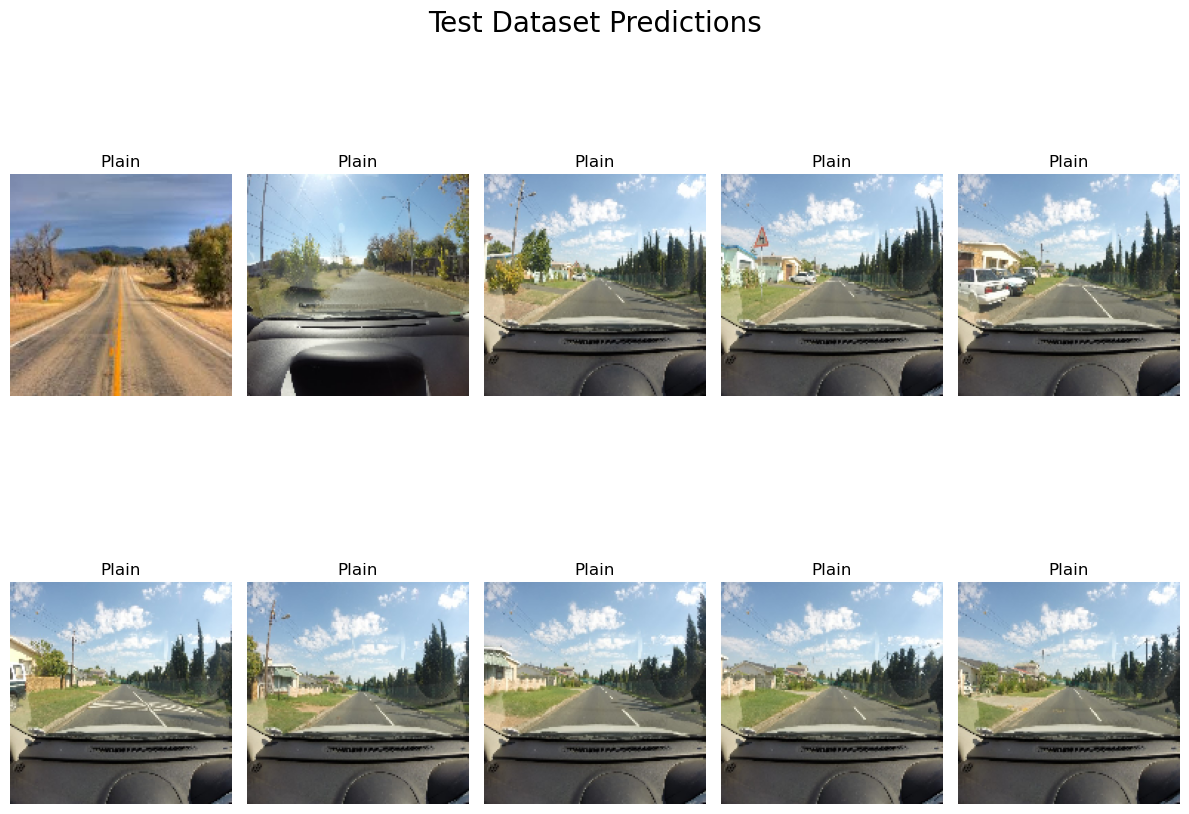

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [23]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

32/32 [==============================] - 4s 112ms/step - loss: 0.5758 - accuracy: 0.8580


In [24]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.5757768154144287
Test Accuracy: 0.8579823970794678


The test loss and test accuracy is the same as validation loss and validation accuracy at the last step since the testing and validation datasets are same.

### **8. Plotting the Classification Metrics**

### **i. Confusion Matrix**

In [25]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

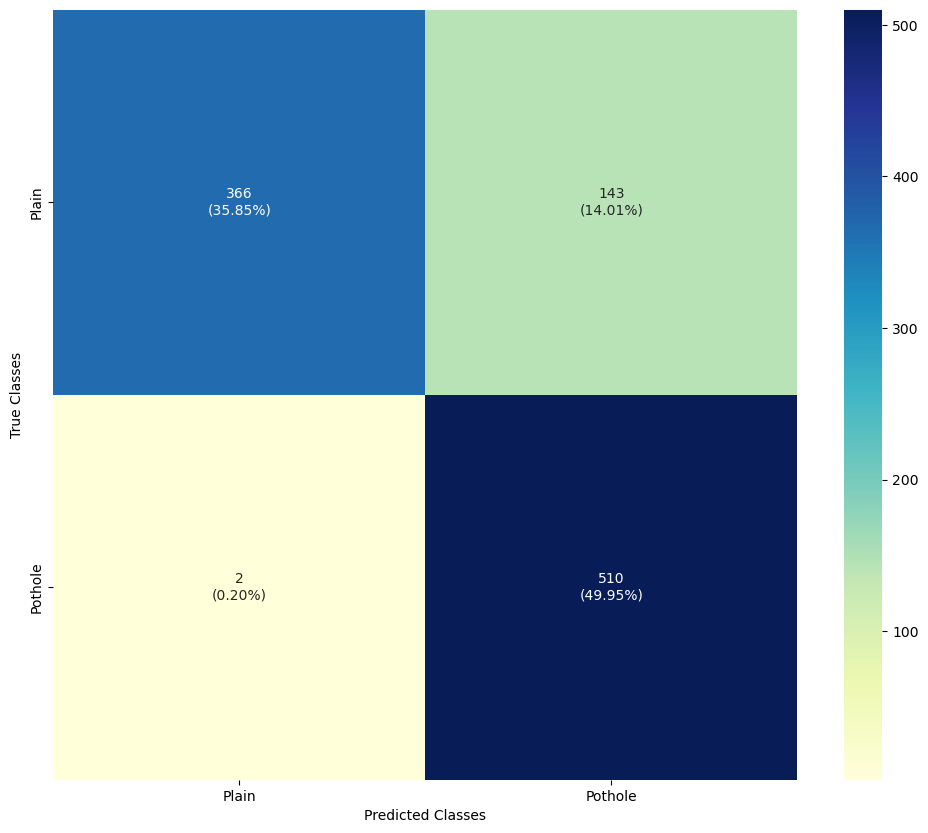

In [26]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [27]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

       Plain       0.99      0.72      0.83       509
     Pothole       0.78      1.00      0.88       512

    accuracy                           0.86      1021
   macro avg       0.89      0.86      0.86      1021
weighted avg       0.89      0.86      0.86      1021



### **9. Wrong Predictions**

Let's see where the model has given wrong predictions and what were the actual predictions on those images.

In [28]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [29]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

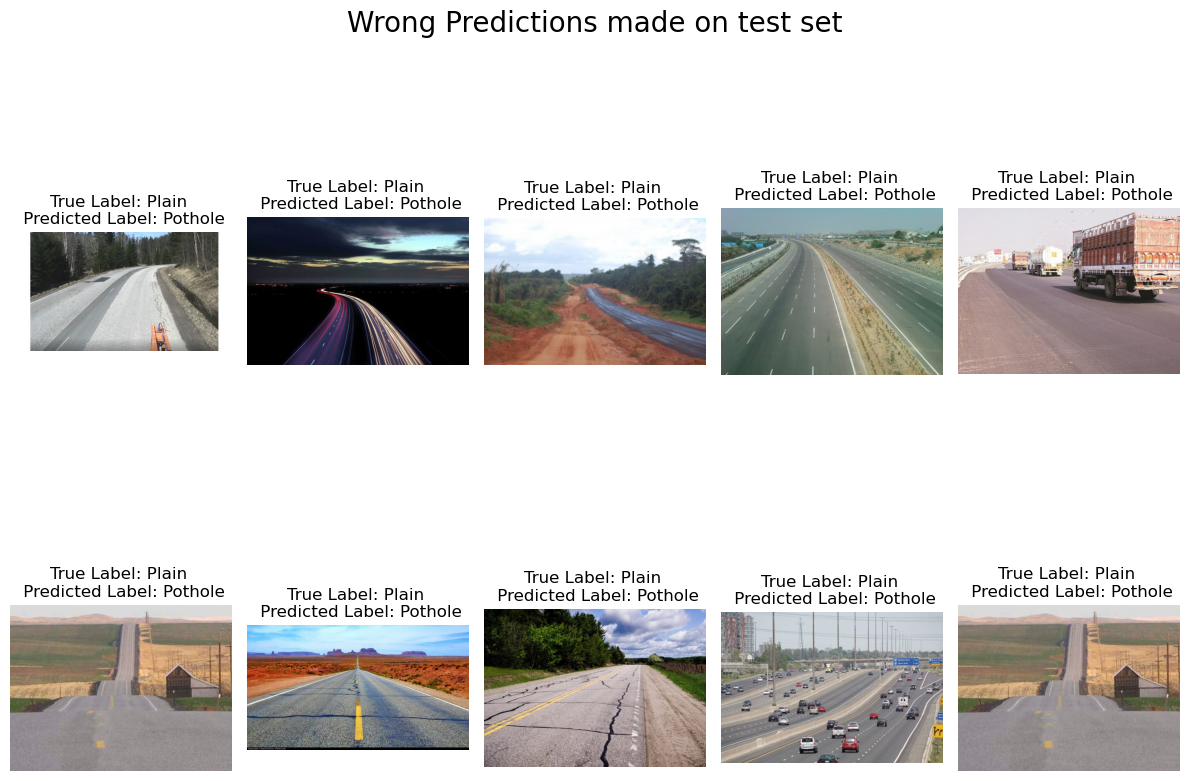

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()